# Developing and Evaluating a Survival Analysis – Project 1

This assignment introduces the process of building a survival analysis model, which is essential for predicting future outcomes based on performance data. This hands-on experience is critical in order to tackle real-world survival problems in health care, business, marketing, and other domains. A real-world dataset is used in this assignment to measure the developers' performance in executing tasks in a project and to identify differences when employing two methods.

## Objective(s):

* Build a survival model using performance data.

* Consider ethical implications in model design and reflect on how forecasting decisions can impact stakeholders.

## Load the dataset and neccessary libraries

In [ ]:
!pip install lifelines

In [ ]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from scipy.interpolate import interp1d
from lifelines.statistics import logrank_test
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# Loading the dataset
# Loading the dataset
df=pd.read_csv('DSC-517-RS-DevelopersMilestones-Dataset.csv')
#  Working with copy of the dataset
data=df.copy()

## Data Preprocessing

### Time-to-complete

In [ ]:
# Processing time to complete
data['time'] = data['implement'].fillna(
    data[['solution','line','method','class','file','folder','problem','issue']].max(axis=1)
)
data['time'] = pd.to_numeric(data['time'], errors='coerce')


### Correctness Indicators

Correctness Indicators: right folder, right file, right class, right method, right lines, sound solution, and correct

In [ ]:
# Converting completeness to binary
data['correctness'] = ((data['right folder'] == 'y') &
                       (data['right file'] == 'y') &
                       (data['right class'] == 'y') &
                       (data['right method'] == 'y') &
                       (data['right lines'] == 'y') &
                       (data['sound solution'] == 'y') &
                       (data['correct'] == 'y')).astype(int)
data['correctness'].value_counts()

,count
correctness,
0,18
1,8


### Separate the dataset into two groups: control and treatment.

In [ ]:
# separing data in two groups
# Separate data for Control and Treatment groups
data_control = data[data['group'] == 'Control']
data_treatment = data[data['group'] == 'Treatment']


### Kaplan Meier Survival analysis

In [ ]:
# Create KaplanMeierFitter
kmf = KaplanMeierFitter()

#### Computing Kaplan Meier Curves for each group

##### Control group

In [ ]:
# Fit Kaplan Meier for Control group
kmf.fit(data_control['time'], event_observed=data_control['correctness'], label='Control')
# Survival function
survival_control = kmf.survival_function_
survival_control

,Control
timeline,
0.0,1.000000
19.0,1.000000
27.0,0.916667
28.0,0.916667
31.0,0.916667
43.0,0.814815
51.0,0.814815
56.0,0.814815
57.0,0.814815


##### Treatment group

In [ ]:
# Fit Kaplan Meier to Treatment group
kmf.fit(data_treatment['time'], event_observed=data_treatment['correctness'], label='Treatment')
# Survival function
survival_treatment = kmf.survival_function_
survival_treatment

,Treatment
timeline,
0.0,1.000000
26.0,0.923077
30.0,0.846154
32.0,0.769231
38.0,0.769231
43.0,0.683761
46.0,0.683761
48.0,0.683761
50.0,0.512821


In [ ]:
# Combining into one DataFrame
survival_table = pd.DataFrame({
    'Control_Survival_Probability': survival_control['Control'],
    'Treatment_Survival_Probability': survival_treatment['Treatment']
})


survival_table

,Control_Survival_Probability,Treatment_Survival_Probability
timeline,,
0.0,1.000000,1.000000
19.0,1.000000,NaN
26.0,NaN,0.923077
27.0,0.916667,NaN
28.0,0.916667,NaN
30.0,NaN,0.846154
31.0,0.916667,NaN
32.0,NaN,0.769231
38.0,NaN,0.769231


## Plot Kaplan-Meier Survival Curve

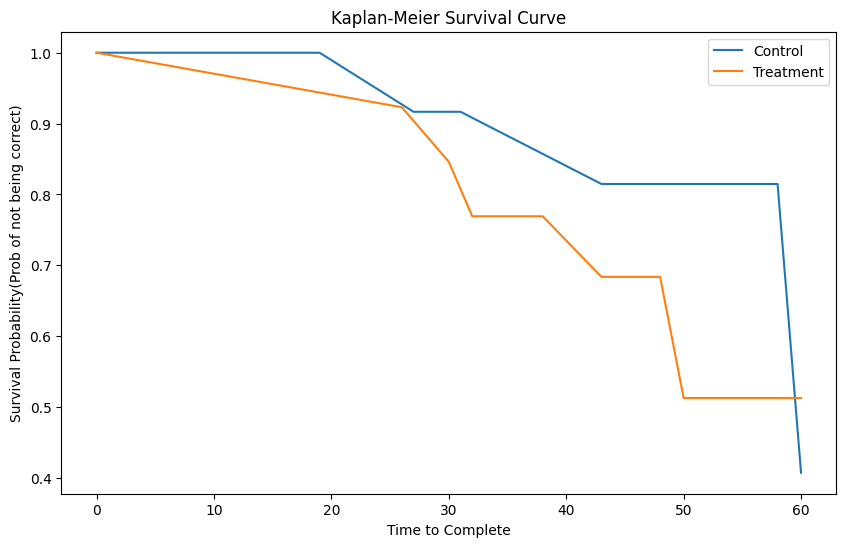

In [ ]:
#plotting combined Kaplan Meier survival curve from computed
plt.figure(figsize=(10, 6))
plt.plot(survival_control.index, survival_control['Control'], label='Control')
plt.plot(survival_treatment.index, survival_treatment['Treatment'], label='Treatment')
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time to Complete')
plt.ylabel('Survival Probability(Prob of not being correct)')
plt.legend()
plt.show()

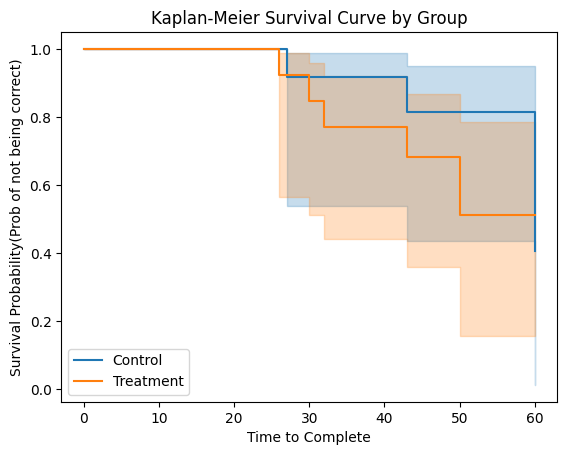

In [ ]:
# Plotting using plot_survival_fuction
# Fit Kaplan-Meier for Control group
kmf.fit(data_control['time'], event_observed=data_control['correctness'], label='Control')
ax = kmf.plot_survival_function()

# Fit Kaplan-Meier for Treatment group
kmf.fit(data_treatment['time'], event_observed=data_treatment['correctness'], label='Treatment')
kmf.plot_survival_function(ax=ax)

plt.title('Kaplan-Meier Survival Curve by Group')
plt.xlabel('Time to Complete')
plt.ylabel('Survival Probability(Prob of not being correct)')
plt.show()

Kaplan Meier curves for the time until success(correct), stratified by whether developers are in control or treatment reveals that time until success(correct)is lower for developers in treatment group. This imply better peformance in the treatment group.

The control group have higher survival curves; this imply over time more developers are yet to to succeed(correct) hence worst performance.



### Log-Rank Test

In [ ]:
# Perform Log-Rank Test
results = logrank_test(data_control['time'], data_treatment['time'],
                       event_observed_A=data_control['correctness'],
                       event_observed_B=data_treatment['correctness'])

# Print the results
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.73 0.39      1.35

Log Rank test compares distribution of control and treatment curves to determine if there is significant difference. The results above reveas log rank p-value(0.39)>0.05 hence there is no statistically significant difference between the distribution of the survival curves of control and treatment.


### Cox Proportional Hazards Model

In [ ]:
# Create a copy of data for CPH
cox_data_0 = data[['time','correctness', 'group']].copy()

# Convert group to numeric by one hot encoding
cox_data_0 = pd.get_dummies(cox_data_0, columns=['group'], drop_first=True)

# Creat and Fit model
cph_0=CoxPHFitter()
cph_0.fit(cox_data_0, duration_col='time', event_col='correctness', show_progress=True)

Iteration 1: norm_delta = 3.11e-01, step_size = 0.9500, log_lik = -21.70380, newton_decrement = 3.62e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.07e-02, step_size = 0.9500, log_lik = -21.34120, newton_decrement = 1.52e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.13e-03, step_size = 0.9500, log_lik = -21.33968, newton_decrement = 4.50e-06, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.02e-07, step_size = 1.0000, log_lik = -21.33967, newton_decrement = 3.21e-13, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 26 total observations, 18 right-censored observations>

In [ ]:
cph_0.print_summary()

<lifelines.CoxPHFitter: fitted with 26 total observations, 18 right-censored observations>
             duration col = 'time'
                event col = 'correctness'
      baseline estimation = breslow
   number of observations = 26
number of events observed = 8
   partial log-likelihood = -21.34
         time fit was run = 2025-12-03 14:35:41 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
group_Treatment  0.62      1.86      0.74           -0.83            2.07                0.44                7.91

                 cmp to    z    p  -log2(p)
covariate                                  
group_Treatment    0.00 0.84 0.40      1.32
---
Concordance = 0.60
Partial AIC = 44.68
log-likelihood ratio test = 0.73 on 1 df
-log2(p) of ll-ratio test = 1.35

The findings of fitting CPH model using features time,correctness and group shown above reveals chance of success(correct) of developers in the treatment group is 1.86 times higher than chance of success for developers in control group. However the high p-value(0.40>0.05) associated with group_Treatment indicate the result is not significant hence consistent results with Log-Rank test earlier conducted.

In [ ]:
# Including additional predictors
# Create a copy of data for CPH
cox_data = data[['time','method','solution','correctness', 'group']].copy()
# Handling missing values in cox_data by imputing using max
cox_data.fillna(cox_data.max(), inplace=True)

# Convert group to numeric by one hot encoding
cox_data = pd.get_dummies(cox_data, columns=['group'], drop_first=True)

# Creat and Fit model
cph=CoxPHFitter()
cph.fit(cox_data, duration_col='time', event_col='correctness', show_progress=True)

Iteration 1: norm_delta = 1.79e+00, step_size = 0.9500, log_lik = -21.70380, newton_decrement = 9.93e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.02e-01, step_size = 0.9500, log_lik = -12.02915, newton_decrement = 1.22e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.75e-01, step_size = 0.9500, log_lik = -10.70226, newton_decrement = 8.27e-02, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.27e-02, step_size = 1.0000, log_lik = -10.61429, newton_decrement = 9.07e-04, seconds_since_start = 0.0
Iteration 5: norm_delta = 4.19e-04, step_size = 1.0000, log_lik = -10.61337, newton_decrement = 1.40e-07, seconds_since_start = 0.0
Iteration 6: norm_delta = 6.75e-08, step_size = 1.0000, log_lik = -10.61337, newton_decrement = 3.50e-15, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 26 total observations, 18 right-censored observations>

In [ ]:
# Display result
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 26 total observations, 18 right-censored observations>
             duration col = 'time'
                event col = 'correctness'
      baseline estimation = breslow
   number of observations = 26
number of events observed = 8
   partial log-likelihood = -10.61
         time fit was run = 2025-12-02 20:56:24 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
method          -0.05      0.95      0.04           -0.13            0.02                0.87                1.03
solution        -0.15      0.86      0.07           -0.28           -0.02                0.76                0.98
group_Treatment  1.81      6.14      1.05           -0.23            3.86                0.79               47.62

                 cmp to     z    p  -log2(p)
covariate                                   
method             0.00 -1.34 0.18      2.48
solution           0.00 -2.30 0.02      5.53
group_Treatment    0.00  1.74 0.08      3.60
---
Concordance = 0.94
Partial AIC = 27.23
log-likelihood ratio test = 22.18 on 3 df
-log2(p) of ll-ratio test = 14.03

The findings of fitting CPH model using features time,method,solution,correctness and group shown above reveals chance of success(correct) of developer in the treatment group is 6.14 times higher than chance of success for developers in control group. However the high p-value associated with group_Treatment indicate the result is not significant hence consistent results with Log-Rank test earlier conducted.

For the features method and solution the hazard ratios(exp(coef)) are lest than 1 implying risks decrease hence developers in treatment are less likely to succeed or perform better.

### Results Summary

From the analysis we can conclude:-

  * Kaplan Meier curves reveals difference between the two groups of developers where time until success(correct) is lower for developers in treatment group. This imply better peformance in the treatment group.

  * Log rank p-value(0.39)>0.05 hence there is no statistically significant difference between the distribution of the survival curves of control and treatment.

  * Cox model shows developers in the treatment group is 1.86 times higher than chance of success for developers in control group. However the high p-value(0.40>0.05) associated with group_Treatment indicate the result is not significant hence consistent results with Log-Rank test earlier conducted.

  The developers in the treatment group performed better based on Kaplan Meier curves and Hazard ratio.However, the difference were not significant.

  The limitation of the analysis is on data quality and assumption violation. The size of the dataset might not be reprsentative enough to enable inference and identify any significant difference among the group of develpoers. It is also noted that KM curves crosses possible indication of violation of cox proportional hazard assumption of constant hazard.

### Ethical Reflection

The results of the forecast of task completion time and correctness can impacts various stakeholders as elaborated:-

  * Businesses major focus is allocation of resources to their various project and timelines of projects.They need to make decision on who to engage for timely completion and know resource requirements for each stages upto completion.Based on the results the difference in time to success(correct completion) noted by Kaplan Meier curves they can go for treatment when time is of essence and resources are available however, this was not significant as per the other test hence can engage any of the developers.

  * Consumers focus is product availability and quality. The focus might them in adjusting these by evaluating developers who are likely to complete on time and correctly.

  * Investors major concern for developers is excercution capability. They would like to make decision who can execute the project within the required time and correctly.Based on the results the difference in time to success(correct completion) noted by Kaplan Meier curves they can go for treatment when faster excercution is required however, this was not significant as per the other test hence can engage any of the developers.

The forecast can contribute to equitable  decicion making in light of christian world view when righteous jugment is made based on data but not opinion.By considering all the 3 test above equitable decision will be made since no significant difference is noted.However, focusing only the Kaplan Meier curves will destract from equitable decision making and lead to engaging of developers on the treatment group.

The steps I have undertaken to ensure fairness and trasparency in forecasting proccess include documenting the process to ensure the results are reproducible. On the same note further test/ validation were undertaken to ensure no quick wins and this resulted to no significant different in the two groups.

To ensure the forecast and overall analysis complies with current legislation, regulations, and standards for the industry; I would ensure transparency by ensuring clear governance policies and at the same time ensure confidentiality.



